# Anxcor Usage Part I
## Organizing Processing Graphs

If you haven't already gone through the Anxcor Processing series, I reccomend you look through it first before starting this series.

Before digging in to how Anxcor organizes the crosscorrelation workflow, Lets review the generalized crosscorrelation workflow:

1) Cut data into x amount of windows per station

2) For every station-window, process the data to maximize the ambient noise field. 

3) Crosscorrelate every station with every other station for a given window

4) Stack the station-pair correlations

The dimensionality of the compute graph lends itself to separation into 2 stages.

* A *Station-Window* stage, where 1), 2), and 3) can operate in a parallel manner.

* A *Inter-Window* stage, step 4), which requires two different windows per station-pair to execute.

A handy graphic is included below to visualize the compute graph

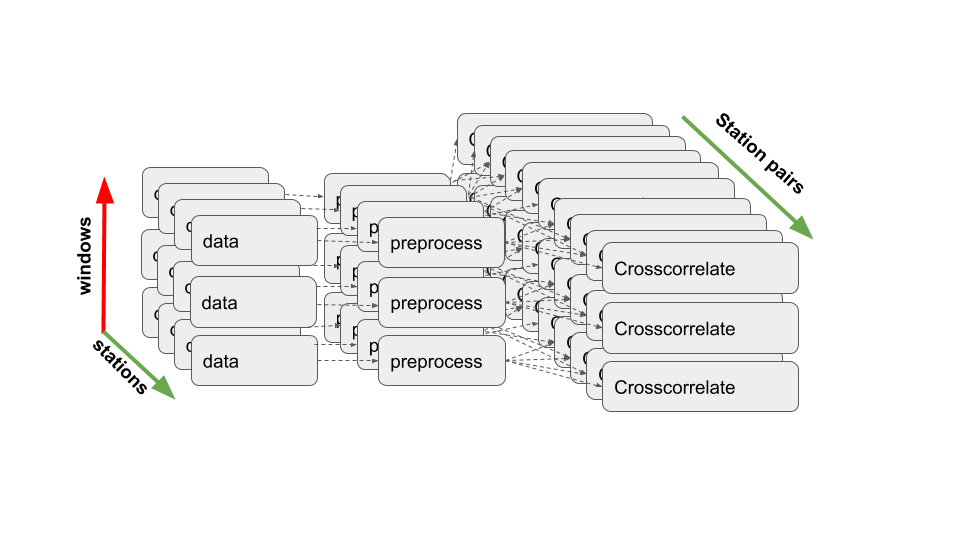

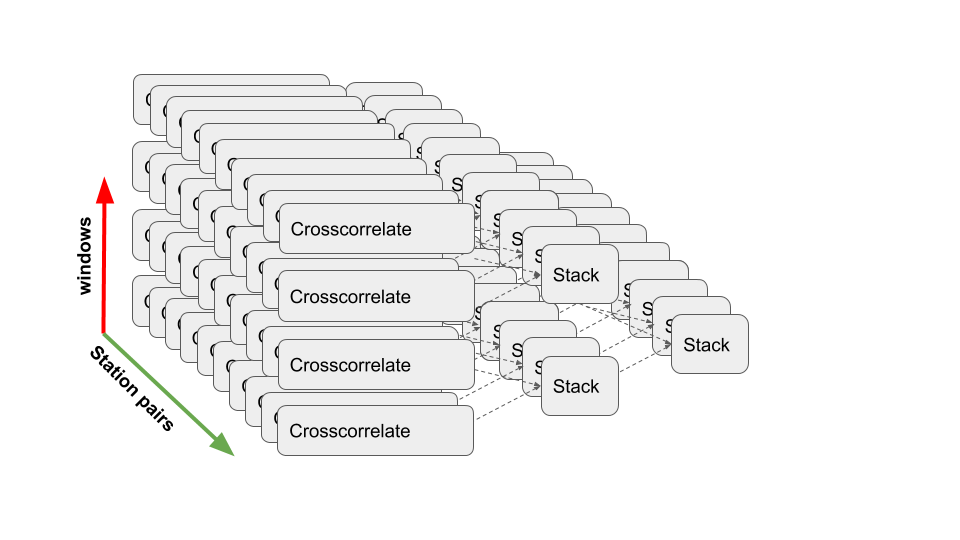

In [1]:
from IPython.display import Image
from IPython.display import display
x = Image(filename='part_1_graph.png')
y = Image(filename='part_2_graph.png')
display(x)
display(y)

Anxcor uses the ```core.Anxcor``` class to manage processing parameters, create the compute graph, and execute both stages of processing. It requires a single positional argument to instatiate ```window_length```. Anxcor follows a utctimestamp protocol where 1.0 = 1 second, 1.5 = 1.5 seconds, 60.0 = 1 minute, and so forth. Lets tell anxcor to create a compute graph with a time window of 10 minutes:

In [2]:
from anxcor.core import Anxcor
anxcor_main = Anxcor(60*10.0)

### The Station-Window Stage: Data

Anxcor assumes that every user may have data structured differently on file. There already exist a plethora of solutions to accessing remote data, and for organizing data on disk. All anxcor wants is an object which extends AnxcorDatabase, and implements:

* get_stations()

* get_waveforms()

In [3]:
from typing import List
from obspy.core import Stream
class AnxcorDatabase:
    """ An interface for providing obspy.core.Stream objects to Anxcor objects

    get_stations() : List[str]
        returns a list of all stations in the dataset, formatted as a string with a network code
        e.g. 'Network.Station' ex: 'UU.1'

    get_waveforms(network : str =None, station : str =None,
                 starttime : float =None,endtime : =None,**kwargs) -> Stream:
        returns an obspy Stream of waveforms. Must take the kwargs:
        network and station as strings, and starttime, endtime as UTCDateTime timestamps
    """

    def __init__(self):
        pass

    def get_stations(self)-> List[str]:
        """
        returns a list of all stations in the dataset, formatted as a string with a network code
        e.g. 'Network.Station' ex: 'UU.1'

        Returns
        -------
        List[str]
            a list of strings representing stations. Must be formatted 'network_code.station_code'
        """
        raise NotImplementedError('Method: \'get_stations()\' method is not implemented')

    def get_waveforms(self,**kwarg_execute)->Stream:
        """
        returns an obspy Stream of waveforms

        Parameters
        ----------
        network : str,
            network to get waveform from. is called as a non-optional keyword-argument
        station : str,
            station to get waveform from. is called as a non-optional keyword-argument
        starttime : float,
            starttime of waveform in UTCDateTime timestamp. Non-optional keyword-argument
        endtime : float,
            endtime of waveform in UTCDateTime timestamp. Non-optional keyword-argument

        Returns
        -------
        Stream
            an obspy stream of traces

        Note
        ----
        Anxcor leaves both removing instrument response and ensuring continuity of data up to the user.
        If a given get_waveforms() query cannot deliver continuous data, it is perfectly fine to return a None object
        instead of an obspy Stream. Anxcor will handle the missing data accordingly.
        """
        raise NotImplementedError('Method: \'get_waveforms()\' is not implemented!')

You can also import this interface via ```from anxcor.containers import AnxcorDatabase```.

We have purposefully not provided a default implementation of this AnxcorDatabase class, because every work group tends to have their own way of organizing data. Rather than force a particular organization scheme, we leave it up to you to develop your own interface.

**However**, a package developed by NIOSH MINING called [obsplus](https://niosh-mining.github.io/obsplus/notebooks/intro.html) we have found is an excellent candidate for creating a generalized implementation. After following the steps to download obsplus, one potential implementation of AnxcorDatabase can be:

In [4]:
from obsplus.bank import WaveBank

class WavebankWrapper(AnxcorDatabase):

    def __init__(self, directory):
        super().__init__()
        self.bank = WaveBank(directory,name_structure='{network}.{station}.{channel}.{time}')
        self.bank.update_index()

    def get_waveforms(self, **kwargs):
        stream =  self.bank.get_waveforms(**kwargs)
        traces = []
        for trace in stream:
            data = trace.data[:-1]
            header = {'delta':   trace.stats.delta,
                      'station': trace.stats.station,
                      'starttime':trace.stats.starttime,
                      'channel': trace.stats.channel,
                      'network': trace.stats.network}
            traces.append(Trace(data,header=header))
        return Stream(traces=traces)

    def get_stations(self):
        df = self.bank.get_availability_df()

        def create_seed(row):
            network = row['network']
            station = row['station']
            return network + '.' + station

        df['seed'] = df.apply(lambda row: create_seed(row), axis=1)
        unique_stations = df['seed'].unique().tolist()
        return unique_stations

Notice the implementation essentially copies the header information into a new dict. While not strictly necessary, the approach of only retaining needed metadata allows for a much cleaner processing object farther down the pipeline.

For this tutorial, we will be using data directly from IRIS, so we will need to adapt the FSDN client to implement AnxcorDatabase's interface

In [17]:
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime, Stream, Trace

class IRISWrapper(AnxcorDatabase):

    def __init__(self):
        super().__init__()
        self.client    =  Client("IRIS")
        self.station_list = ['S01','S02']
        self.pre_filter = (0.003, 0.005, 40.0, 45.0)

    def get_waveforms(self,starttime=0,endtime=0,station=0,network=0, **kwargs):
        traces = []
        stream =  self.client.get_waveforms(network, station, "*", "H*", starttime,endtime,attach_response=True)
        stream.remove_response(output='DISP', pre_filt=self.pre_filter)
        for trace in stream:
            data = trace.data[:-1]
            header = {'delta':   trace.stats.delta,
                      'station': trace.stats.station,
                      'starttime':trace.stats.starttime,
                      'channel': trace.stats.channel,
                      'network': trace.stats.network}
            traces.append(Trace(data,header=header))

        return Stream(traces=traces)

    def get_stations(self):
        station_list = []
        for station in self.station_list:
            station_list.append('YB.{}'.format(station))
        return station_list
    

to add the dataset to the main anxcor object, supply a name for the database

In [29]:
anxcor_main = Anxcor(60*10.0)
anxcor_main.add_dataset(IRISWrapper(), 'IMUSH_ST_HELENS_CRATER')

### The Station-Window Stage: Conversion, Resampling, Cross-Correlation

Anxcor's main object ```Anxcor``` has three baked-in methods that are currently impossible to remove: Conversion from a stream to an XArray, resampling of the original timeseries, and cross-correlation. However, we can specify what parameters to resample and crosscorrelate by:

* **Resampling**: we are able to set the target sampling rate and the taper percent.

* **Crosscorrelate**: we can define how much of the tau delay to keep from $\tau=0.0$s.

Because the corresponding XArrayProcessor objects have already been instantiated by ```Anxcor```, we need to use the ```set_task_kwargs()``` method to set any parameters. Any Processing function that does not have to be explicitly set by the user is considered a 'task'

In [30]:
resample_kwargs = dict(taper=0.05,target_rate=20.0)
correlate_kwargs= dict(taper=0.1,max_tau_shift=50.0)
anxcor_main.set_task_kwargs('resample',resample_kwargs)
anxcor_main.set_task_kwargs('crosscorrelate',correlate_kwargs)

### The Station-Window Stage: Other Processes

Aside from mandatory 'tasks', we could tell anxcor to perform a series of processing steps. Steps are executed in the order they are assigned to anxcor_main via ```add_process```. So if we wanted to remove the mean and trend prior to applying a one-bit normalization scheme, we should do the following:

In [31]:
from anxcor.xarray_routines import XArrayRemoveMeanTrend, XArrayProcessor
import numpy as np
class XArrayOneBit(XArrayProcessor):
    """
    one bit normalization
    """

    def __init__(self,**kwargs):
        super().__init__(**kwargs)

    def _single_thread_execute(self, xarray,*args, **kwargs):
        return np.sign(xarray)

    def _add_operation_string(self):
        return 'one-bit-norm'

    def _get_process(self):
        return 'one-bit-norm'
    
anxcor_main.add_process(XArrayRemoveMeanTrend())
anxcor_main.add_process(XArrayOneBit())

Anxcor's private members are private for a reason, but if we wanted to ensure our processing approach is added properly, it is possible to print out the task/process dictionary contained in anxcor main:

In [32]:
for key, value in anxcor_main._data._tasks.items():
    print(key)
    print(value)

data
xconvert
resample
process
{'remove_mean_trend': <anxcor.xarray_routines.XArrayRemoveMeanTrend object at 0x7f03c43a9e48>, 'one-bit-norm': <__main__.XArrayOneBit object at 0x7f03c43a9588>}
crosscorrelate
combine
stack


### Inter-Window Stage

We've covered most of the heavy compute aspect of the crosscorrelation graph. All that remains is the correlegram stacking. We'd also like to combine all our data into a single xarray DataSet so we can peruse the data much like a pandas dataframe. 

Since we'd like to reserve most of our memory and compute resources for the station-window processing stage, Anxcor performs a binary tree reduce on all produced correlegrams. Once a single station-pair has been maximally stacked, data are then aggregated via another binary tree reduce into a single object through a task called 'combine'. None of this, of course, you have to explicitly worry about.

We have everything we need to perform a basic crosscorrelation stack, so lets do so. All we need is to provide ```anxcor_main``` with a list of utcstarttime timestamps. As we're doing this on a single thread, it might take a little bit, so just be patient. On an intel i5 machine, we observe 2 data_queries -> crosscorrelation time of about 25s.

In [33]:
starttime  = UTCDateTime("2005-6-22 12:00:00").timestamp
starttimes = []
for window_number in range(0,4):
    starttimes.append(starttime +60*10.0*window_number)
    print(UTCDateTime(starttimes[-1]))

2005-06-22T12:00:00.000000Z
2005-06-22T12:10:00.000000Z
2005-06-22T12:20:00.000000Z
2005-06-22T12:30:00.000000Z


In [34]:
xarray_dataset=anxcor_main.process(starttimes)

In [35]:
array=xarray_dataset['src:IMUSH_ST_HELENS_CRATER rec:IMUSH_ST_HELENS_CRATER']

First, lets verify the autocorrelation of station S01 has a maxima at $\tau=$0s

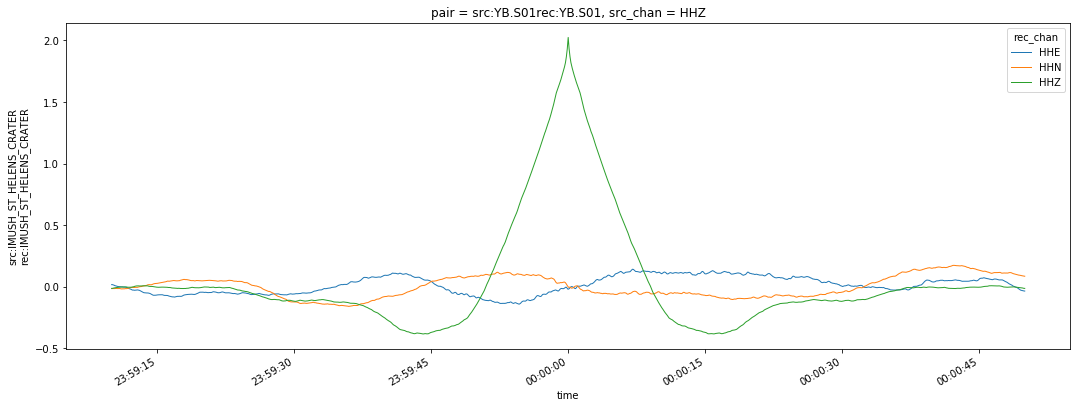

In [36]:
array.loc[dict(pair='src:YB.S01rec:YB.S01',src_chan='HHZ')].plot.line(x='time',aspect=3, size=6,linewidth=1)

This is, infact, what we observe. Perfect. Now, lets look at the crosscorrelation function between station S01 and S02

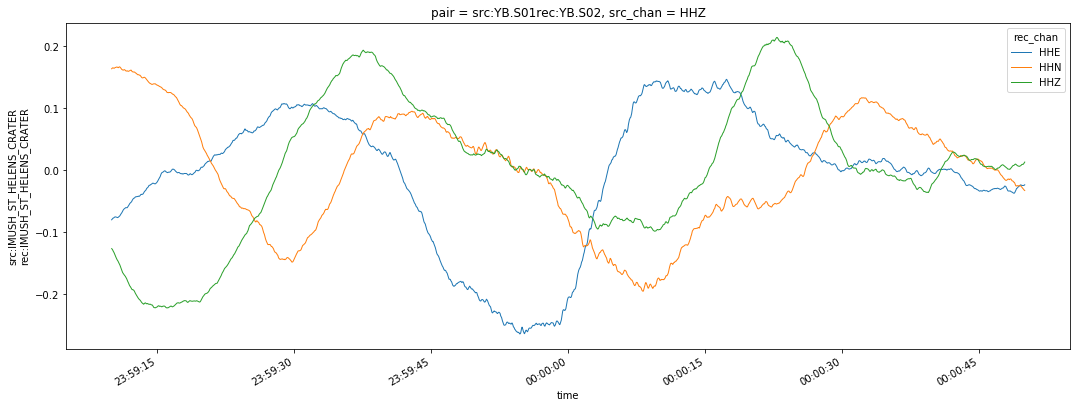

In [37]:
array.loc[dict(pair='src:YB.S01rec:YB.S02',src_chan='HHZ')].plot.line(x='time',aspect=3, size=6,linewidth=1)

In the next tutorial we'll dive a bit deeper into how to get file IO output at specific stages of the compute graph. 